In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from models.training import test

ModuleNotFoundError: No module named 'torchvision'

### Load surrogate model

The following script initializes a model and loads the dataset. Afterwards, the model is trained on the data. 
If the 'train' flag is 0, the model is not trained. Hence, keep it so unless you want to pretrain a surrogate model yourself. 

The pre-trained model is trained on samples with ids from 0 to 50000. The range of loaded data is defined by 'start_id' (first) and 'n_samples' (last).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate
import torch

In [2]:
# pre-shots: 0 ps

run_1 = np.loadtxt('../lisa_data/run_49169.txt',dtype=float)
run_2 = np.loadtxt('../lisa_data/run_49171.txt',dtype=float)

run_0 = np.loadtxt('../lisa_data/run_49227.txt', dtype=float)

# subtract the background
run_1 = run_1 - run_0*30/1000
run_2 = run_2 - run_0*30/1000

In [3]:
import sys
sys.path.append('..')
from json import loads

from dataset.sample import Sample
from dataset.utils import store_single_hdf5

config = '../dataset/config.json'

with open(config) as f:
    config = loads(f.read())
s = Sample(config, 'default', 15)

In [14]:
class Reflect(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.cat([x, x.flip(-1)], -1)

In [78]:
def preproc(x):
    x = torch.Tensor(x)
    eps = torch.sort(x.reshape(-1))[0][int(0.1*x.numel())].item()
    x = torch.clip(x, eps)
    x = (x - x.min()) / (x.max() - x.min())
    return torch.clip(x, 1e-3).log10()

In [87]:
x_exp = preproc(run_1) #np.log(run_1-run_1.min()+1)
x_sim = preproc(s.simres) #np.log(s.simres)#[:,155:275]

#x_exp = interpolate(torch.tensor(x_exp).unsqueeze(0).unsqueeze(0), (128,16)).squeeze()
#x_sim = interpolate(torch.tensor(x_sim).unsqueeze(0).unsqueeze(0), (128,16)).squeeze()

x_exp = (x_exp - x_exp.min()) / (x_exp.max() - x_exp.min())
x_sim = (x_sim - x_sim.min()) / (x_sim.max() - x_sim.min())

x_exp_proj = x_exp.mean(1)
x_sim_proj = x_sim.mean(1)

x_exp_proj = x_exp_proj - x_exp_proj.mean()
x_sim_proj = x_sim_proj - x_sim_proj.mean()

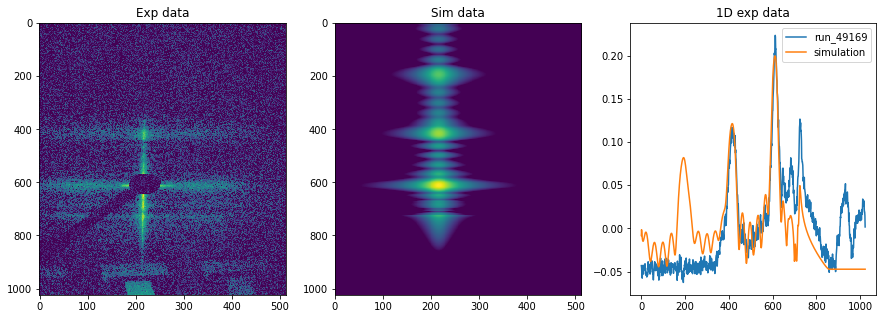

In [88]:
fig, ax = plt.subplots(1,3, figsize = [15,5])
ax[0].imshow(x_exp, interpolation='nearest', aspect = 'auto')
ax[0].set_title('Exp data')
ax[1].imshow(x_sim, interpolation='nearest', aspect = 'auto')
ax[1].set_title('Sim data')
ax[2].plot(x_exp_proj, label = 'run_49169')
ax[2].plot(x_sim_proj, label = 'simulation')
ax[2].set_title('1D exp data')
ax[2].legend()

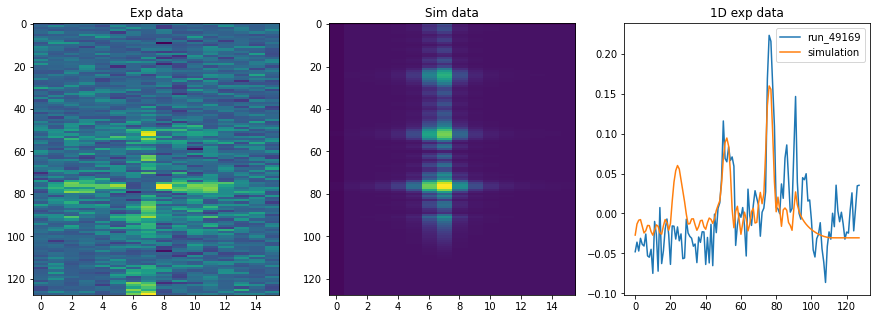

In [6]:
fig, ax = plt.subplots(1,3, figsize = [15,5])
ax[0].imshow(x_exp, interpolation='nearest', aspect = 'auto')
ax[0].set_title('Exp data')
ax[1].imshow(x_sim, interpolation='nearest', aspect = 'auto')
ax[1].set_title('Sim data')
ax[2].plot(x_exp_proj, label = 'run_49169')
ax[2].plot(x_sim_proj, label = 'simulation')
ax[2].set_title('1D exp data')
ax[2].legend()

In [10]:
x_exp = np.log(run_1-run_1.min()+1)

In [7]:
%run scripts/train_surrogate.py --verbose 1 --start_id 0 --n_samples 1000 --augmentation 0 --distance 'l2' --train 1 --in_shape 128 16 --n_layers 12 --n_epochs 1000 --batch_size 16 --model 'fcnet' --minmax 1 --log 1 --data_path '/bigdata/hplsim/aipp/Maksim/BA_simulation/complete/' --savedir 'saved_models/'

100%|██████████| 200/200 [00:00<00:00, 325.38it/s]



 Data loaders created
[Epoch [1/1000], Train MSE (log): -1.30, Val MSE (log): -1.29
[Epoch [6/1000], Train MSE (log): -2.23, Val MSE (log): -2.24
[Epoch [11/1000], Train MSE (log): -2.29, Val MSE (log): -2.30
[Epoch [16/1000], Train MSE (log): -2.31, Val MSE (log): -2.31
[Epoch [21/1000], Train MSE (log): -2.31, Val MSE (log): -2.32
[Epoch [26/1000], Train MSE (log): -2.32, Val MSE (log): -2.33
[Epoch [31/1000], Train MSE (log): -2.33, Val MSE (log): -2.32
[Epoch [36/1000], Train MSE (log): -2.34, Val MSE (log): -2.32
[Epoch [41/1000], Train MSE (log): -2.35, Val MSE (log): -2.33
[Epoch [46/1000], Train MSE (log): -2.36, Val MSE (log): -2.33
[Epoch [51/1000], Train MSE (log): -2.37, Val MSE (log): -2.34
[Epoch [56/1000], Train MSE (log): -2.38, Val MSE (log): -2.33
[Epoch [61/1000], Train MSE (log): -2.39, Val MSE (log): -2.33
[Epoch [66/1000], Train MSE (log): -2.40, Val MSE (log): -2.33
[Epoch [71/1000], Train MSE (log): -2.41, Val MSE (log): -2.32
[Epoch [76/1000], Train MSE (log):

KeyboardInterrupt: 

Let us now load a pre-trained surrogate model and test its performance on our training data. 

Note: if the range (start_id, n_samples) does not intersect with (0,50000), all the samples in the loaded dataset are unseen for the pre-trained model.

In [93]:
pt_name = 'fcnet___1_1_0_l1_12_128_16'
model.load_state_dict(torch.load('./saved_models/'+pt_name, map_location=device))

test_loss = test(loaders['train'], model)
print('Val MSE: {:.4f}'.format(test(loaders['train'], model)))

assert test_loss < 1e-2, "Test loss is too high. Please contact me (Maksim Zhdanov) in Mattermost."

Val MSE: 0.0026


### Visualize the simulation

Let us now visualize how the model is able to simulate GISAXS images.

In [94]:
xs, ys = next(iter(loaders['val']))
x_pred = model(ys.cuda()).cpu().detach()

In [95]:
grid_img = make_grid(xs.unsqueeze(1)[:9], nrow=3).cpu().detach()
grid_img_pred = make_grid(x_pred[:9], nrow=3).cpu().detach()

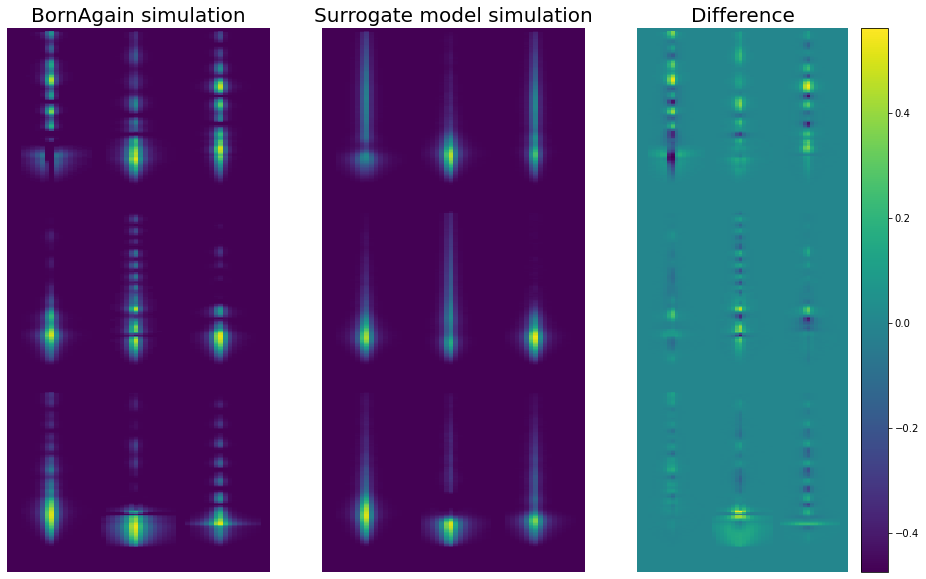

In [96]:
plt.figure(figsize=[16,10])

plt.subplot(1,3,1)
plt.title('BornAgain simulation', fontsize = 20)
plt.imshow(grid_img[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Surrogate model simulation', fontsize = 20)
plt.imshow(grid_img_pred[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Difference', fontsize = 20)
plt.imshow(grid_img[0] - grid_img_pred[0], aspect = 'auto', interpolation='nearest')
plt.axis('off')
plt.colorbar()